In [1]:
!nvidia-smi

Sat May 27 22:29:32 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070 Ti      On | 00000000:01:00.0 Off |                  N/A |
|  0%   49C    P5               26W / 310W|   2193MiB /  8192MiB |     15%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [11]:
import os

###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
###
from tqdm import tqdm
from sklearn.model_selection import train_test_split
#
from PIL import Image
#
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from torch import nn
###
from transformers import CLIPModel, CLIPConfig, CLIPVisionModel
#from transformers import AutoModel, AutoTokenizer
#from transformers import TrainingArguments, Trainer
from transformers import default_data_collator
# Callbacks
from transformers import EarlyStoppingCallback 
from transformers.integrations import TensorBoardCallback
from torch.utils.tensorboard import SummaryWriter

In [12]:
from transformers import CLIPFeatureExtractor, CLIPTokenizer, CLIPTextModel
from transformers import TrainingArguments, AutoTokenizer, CLIPFeatureExtractor

In [13]:
from clip_classes import CLIPTrainer, CLIPDataset
from clip_functions import clip_wrapper_creator
import helper

# Dataset

In [14]:
folder = "/media/andrew/HD-GDU3/498/"
medical_reports = "cleaned_single_image_only_relevant_headings2.csv"
meta_data = "cleaned_single_image_only_relevant_headings_metadata.csv"
image_data = None
image_folder = None
dataset = "NEW_DATASET.csv"
md_location = folder + meta_data
meta_reports = pd.read_csv(md_location)
sample = meta_reports.head()

In [16]:
early_stop = EarlyStoppingCallback(
    early_stopping_patience = 10.0,
    early_stopping_threshold = 0
)
# ( early_stopping_patience: int = 1early_stopping_threshold: typing.Optional[float] = 0.0 ) 

In [17]:
#TEXT_MODEL = "emilyalsentzer/Bio_ClinicalBERT"
#TEXT_MODEL = "clinical-bert-models-trained-on-pseudo-re-identified-mimic-iii-notes-1.0.0/model_outputs/ClinicalBERT_1b/"
TEXT_MODEL = "clinical-bert-models-trained-on-pseudo-re-identified-mimic-iii-notes-1.0.0/model_outputs/Pubmed_ClinicalBERT_1a/"
IMAGE_MODEL = 'openai/clip-vit-base-patch32'
CLIP_MODEL = None
TEST_SIZE = 0.05
BATCH_SIZE = 8
GRADIENT_ACCUMULATION = 2
FP_16 = False
RUN_NAME = 'clip-checkpoints-sentences-bioclinbert-1'
BASE_DIR = '/media/andrew/HD-GDU3/498/'
OUTPUT_DIR = BASE_DIR + RUN_NAME
LEARNING_RATE = 3e-5 #3e-6
WEIGHT_DECAY = 0.1 #0.003, between 0 and .1
OPTIMIZER = "AdamW"
CALLBACKS = [TensorBoardCallback, early_stop]
IMAGE_SIZE = 224
MAX_LEN = 80
EPOCHS = 10
MEAN = torch.tensor([0.42695613, 0.42695613, 0.42695613]) #Image Mean
STD = torch.tensor([0.31928246, 0.31928246, 0.31928246]) #Image STD

## Create Training and Validation Set

# Tensorboard

In [18]:
writer = SummaryWriter()

# Training

In [19]:
dataset = pd.read_csv(dataset)

In [20]:
vision_preprocessor = CLIPFeatureExtractor.from_pretrained(IMAGE_MODEL)

In [21]:
#tokenizer = AutoTokenizer.from_pretrained(TEXT_MODEL)
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [23]:
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=500,
    logging_steps=10,
    learning_rate=LEARNING_RATE, 
    weight_decay=WEIGHT_DECAY, 
    warmup_steps=100,
    fp16=FP_16,
    prediction_loss_only=True,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION, #1
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    report_to='none',
    metric_for_best_model="loss",
    load_best_model_at_end=True
)

In [25]:
DATA_FILE = dataset

In [26]:
from torch.utils.data import Dataset

class CLIPDataset(Dataset):
    def __init__(self, image_paths: list, text: list, mode: str = 'train'):
        self.image_paths = image_paths
        self.tokens = tokenizer(text, 
                                padding = 'max_length',
                                max_length = MAX_LEN, 
                                truncation = True
                               )

        if mode == 'train':
            self.augment = transforms.Compose([
                #transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                #transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD)
            ])
        elif mode == 'test':
            self.augment = transforms.Compose([
                #transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD)
            ])

    def __getitem__(self, idx):
        token = self.tokens[idx]
        return {'input_ids': token.ids, 'attention_mask': token.attention_mask,
                'pixel_values': self.augment(Image.open(self.image_paths[idx]).convert('RGB'))}

    def __len__(self):
        return len(self.image_paths)

In [27]:
df = dataset.dropna()
#test_df = pd.read_csv('test.csv').dropna()
#validate_df = pd.read_csv('validate.csv').dropna()

train_df, test_df = train_test_split(df, test_size=TEST_SIZE)
train_ds = CLIPDataset(image_paths=train_df.image.tolist(),text=train_df.caption.tolist(), mode='train')
test_ds = CLIPDataset(image_paths=test_df.image.tolist(),text=test_df.caption.tolist(), mode='test')
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE,collate_fn=default_data_collator)

# Sample Image

In [28]:
def show_data(batch, idx=0):
    # show image
    img = batch['pixel_values'][idx].permute(1, 2, 0)
    img = STD * img + MEAN
    print('Image shape: ', img.shape)
    plt.imshow(img)
    # show text
    text = tokenizer.decode(batch['input_ids'][idx],  skip_special_tokens=True)
    print('Text: ', text)

torch.Size([8, 80])
torch.Size([8, 3, 224, 224])
Image shape:  torch.Size([224, 224, 3])
Text:  findings suggest mild zone pulmonary edema, but with concern for focal opacification in the left lower lung which may indicate coinciding atelectasis or pneumonia. there is a right - sided picc line that terminates most likely at the confluence of the brachiocephalic veins. the heart is enlarged. there is bilateral hilar congestion, and in addition to mild pulmonary ed


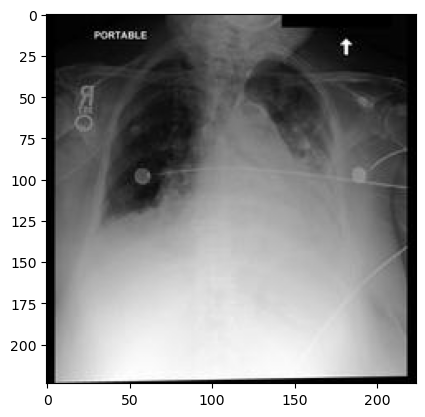

In [29]:
for item in train_dl:
    print(item['input_ids'].shape)
    print(item['pixel_values'].shape)
    break
show_data(item)

In [30]:
vision_encoder = CLIPVisionModel.from_pretrained(IMAGE_MODEL)
#config = CLIPConfig.from_pretrained("openai/clip-vit-base-patch16")
#vision_encoder = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch16", config=config.vision_config)

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.0.self_attn.v_proj.bias', 'text_model.encoder.layers.1.self_attn.v_proj.weight', 'text_model.encoder.layers.5.mlp.fc2.weight', 'text_model.encoder.layers.1.mlp.fc2.bias', 'text_model.encoder.layers.5.layer_norm1.weight', 'text_model.encoder.layers.3.mlp.fc2.bias', 'text_model.encoder.layers.8.mlp.fc1.bias', 'text_model.encoder.layers.3.self_attn.out_proj.bias', 'text_model.encoder.layers.11.self_attn.k_proj.weight', 'text_model.encoder.layers.1.mlp.fc1.bias', 'text_model.encoder.layers.9.self_attn.k_proj.weight', 'text_model.final_layer_norm.weight', 'text_model.encoder.layers.4.self_attn.v_proj.bias', 'text_model.encoder.layers.9.layer_norm1.weight', 'text_model.encoder.layers.9.self_attn.k_proj.bias', 'text_model.embeddings.token_embedding.weight', 'text_model.encoder.layers.0.self_attn.k_proj.weight', 'text_model.encoder.layers.4.mlp.fc2.w

In [31]:
TEXT_MODEL

'clinical-bert-models-trained-on-pseudo-re-identified-mimic-iii-notes-1.0.0/model_outputs/Pubmed_ClinicalBERT_1a/'

In [32]:
text_encoder = CLIPTextModel.from_pretrained(TEXT_MODEL)
#text_encoder = BertModel.from_pretrained("bert-base-uncased")

You are using a model of type bert to instantiate a model of type clip_text_model. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at clinical-bert-models-trained-on-pseudo-re-identified-mimic-iii-notes-1.0.0/model_outputs/Pubmed_ClinicalBERT_1a/ were not used when initializing CLIPTextModel: ['bert.encoder.layer.3.intermediate.dense.weight', 'bert.encoder.layer.5.attention.self.value.bias', 'bert.encoder.layer.3.attention.self.value.weight', 'bert.encoder.layer.5.intermediate.dense.weight', 'bert.encoder.layer.11.output.LayerNorm.weight', 'bert.pooler.dense.bias', 'bert.encoder.layer.7.attention.self.key.bias', 'bert.encoder.layer.5.attention.output.LayerNorm.bias', 'bert.encoder.layer.8.attention.self.key.weight', 'bert.encoder.layer.7.attention.self.value.bias', 'cls.seq_relationship.weight', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.1.attention.self.key.bias', 'bert.encoder.layer.3.attenti

In [33]:
def clip_wrapper_creator():
    """create a dummy CLIPModel to wrap text and vision encoders in order to use CLIPTrainer"""
    config = {'num_hidden_layers': 0,
              'max_position_embeddings': 0,
              'vocab_size': 0,
              'hidden_size': 1,
              'patch_size': 1,
              }

    #DUMMY_CONFIG = CLIPConfig(text_config_dict=config,vision_config_dict=config)
    DUMMY_CONFIG = CLIPConfig(
        text_config_dict = config,
        vision_config_dict = config
    )

    clip = CLIPModel(config=DUMMY_CONFIG)

    # convert projectors to Identity
    clip.text_projection = nn.Identity()
    clip.visual_projection = nn.Identity()

    return clip

In [34]:
#text_encoder = AutoModel.from_pretrained(TEXT_MODEL)
#text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-base-patch32')

clip = clip_wrapper_creator()
clip.text_model = text_encoder
clip.vision_model = vision_encoder

In [35]:
assert text_encoder.config.hidden_size == vision_encoder.config.hidden_size

## Trainer: train using huggingface trainer

In [36]:
def train_model():
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    helper.clear_gpu()
    args.dataloader_num_workers = helper.optimal_workers()
    trainer = CLIPTrainer(clip, args,
                          train_dataset=train_ds,
                          eval_dataset=test_ds,
                          callbacks = CALLBACKS
                         )

    trainer.train()

In [37]:
activate_training = False

In [38]:
if activate_training:
    
    train_model()

    # save pretrained models
    # clip.text_model.save_pretrained('radCLIP')
    # tokenizer.save_pretrained('radCLIP')
    # clip.vision_model.save_pretrained('radCLIP')
    # vision_preprocessor.save_pretrained('radCLIP')

In [39]:
# save pretrained models
FINETUNED_MODEL = 'radCLIP2'
if activate_training:
    clip.text_model.save_pretrained(FINETUNED_MODEL)
    tokenizer.save_pretrained(FINETUNED_MODEL)
    clip.vision_model.save_pretrained(FINETUNED_MODEL)
    vision_preprocessor.save_pretrained(FINETUNED_MODEL)

# Demo

In [40]:
class VisionDataset(Dataset):
    preprocess = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
    ])

    def __init__(self, image_paths: list):
        self.image_paths = image_paths

    def __getitem__(self, idx):
        return self.preprocess(Image.open(self.image_paths[idx]).convert('RGB'))

    def __len__(self):
        return len(self.image_paths)


class TextDataset(Dataset):
    def __init__(self, text: list, tokenizer, max_len):
        self.len = len(text)
        self.tokens = tokenizer(text, padding='max_length',
                                max_length=max_len, truncation=True)

    def __getitem__(self, idx):
        token = self.tokens[idx]
        return {'input_ids': token.ids, 'attention_mask': token.attention_mask}

    def __len__(self):
        return self.len

In [41]:
vision_encoder = CLIPVisionModel.from_pretrained(FINETUNED_MODEL)
tokenizer = AutoTokenizer.from_pretrained(FINETUNED_MODEL)
#tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
text_encoder = CLIPTextModel.from_pretrained(FINETUNED_MODEL)

You are using a model of type clip_vision_model to instantiate a model of type clip_text_model. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at radCLIP2 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.1.self_attn.out_proj.bias', 'vision_model.encoder.layers.10.layer_norm1.weight', 'vision_model.encoder.layers.1.layer_norm2.bias', 'vision_model.encoder.layers.3.self_attn.k_proj.weight', 'vision_model.encoder.layers.3.self_attn.out_proj.bias', 'vision_model.encoder.layers.6.mlp.fc1.weight', 'vision_model.encoder.layers.8.layer_norm1.bias', 'vision_model.encoder.layers.9.mlp.fc1.bias', 'vision_model.encoder.layers.5.self_attn.out_proj.bias', 'vision_model.encoder.layers.7.mlp.fc1.bias', 'vision_model.encoder.layers.2.layer_norm2.bias', 'vision_model.encoder.layers.11.self_attn.v_proj.weight', 'vision_model.encoder.layers.10.mlp.fc2.weight', 'vision_model.encoder.layers.6.self_attn.q_proj.bias

In [42]:
import torch
from tqdm import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import default_data_collator


class CLIPDemo:
    def __init__(self, vision_encoder, text_encoder, tokenizer,
                 batch_size: int = 32, max_len: int = MAX_LEN, device='cuda'):
        """ Initializes CLIPDemo
            it has the following functionalities:
                image_search: Search images based on text query
                zero_shot: Zero shot image classification
                analogy: Analogies with embedding space arithmetic.

            Args:
            vision_encoder: Fine-tuned vision encoder
            text_encoder: Fine-tuned text encoder
            tokenizer: Transformers tokenizer
            device (torch.device): Running device
            batch_size (int): Size of mini-batches used to embeddings
            max_length (int): Tokenizer max length

            Example:
            >>> demo = CLIPDemo(vision_encoder, text_encoder, tokenizer)
            >>> demo.compute_image_embeddings(test_df.image.to_list())
            >>> demo.image_search('یک مرد و یک زن')
            >>> demo.zero_shot('./workers.jpg')
            >>> demo.anology('./sunset.jpg', additional_text='دریا')
        """
        self.vision_encoder = vision_encoder.eval().to(device)
        self.text_encoder = text_encoder.eval().to(device)
        self.batch_size = batch_size
        self.device = device
        self.tokenizer = tokenizer
        self.max_len = 70 #MAX_LEN
        self.text_embeddings_ = None
        self.image_embeddings_ = None
        

    def compute_image_embeddings(self, image_paths: list):
        self.image_paths = image_paths
        datalodear = DataLoader(VisionDataset(
            image_paths=image_paths), batch_size=self.batch_size)
        embeddings = []
        with torch.no_grad():
            for images in tqdm(datalodear, desc='computing image embeddings'):
                image_embedding = self.vision_encoder(
                    pixel_values=images.to(self.device)).pooler_output
                embeddings.append(image_embedding)
        self.image_embeddings_ =  torch.cat(embeddings)

    def compute_text_embeddings(self, text: list):
        self.text = text
        dataloader = DataLoader(TextDataset(text=text, tokenizer=self.tokenizer, max_len=self.max_len),
                                batch_size=self.batch_size, collate_fn=default_data_collator)
        embeddings = []
        with torch.no_grad():
            for tokens in tqdm(dataloader, desc='computing text embeddings'):
                image_embedding = self.text_encoder(input_ids=tokens["input_ids"].to(self.device),
                                                    attention_mask=tokens["attention_mask"].to(self.device)).pooler_output
                embeddings.append(image_embedding)
        self.text_embeddings_ = torch.cat(embeddings)

    def text_query_embedding(self, query: str = ''):
        tokens = self.tokenizer(query, return_tensors='pt')
        with torch.no_grad():
            text_embedding = self.text_encoder(input_ids=tokens["input_ids"].to(self.device),
                                               attention_mask=tokens["attention_mask"].to(self.device)).pooler_output
        return text_embedding

    def image_query_embedding(self, image):
        image = VisionDataset.preprocess(image).unsqueeze(0)
        with torch.no_grad():
            image_embedding = self.vision_encoder(
                image.to(self.device)).pooler_output
        return image_embedding

    def most_similars(self, embeddings_1, embeddings_2):
        values, indices = torch.cosine_similarity(
            embeddings_1, embeddings_2).sort(descending=True)
        return values.cpu(), indices.cpu()

    def zero_shot(self, image_path: str):
        """ Zero shot image classification with label list 
            Args:
                image_path (str): target image path that is going to be classified
                class_list (list[str]): list of candidate classes 
        """
        image = Image.open(image_path)
        image_embedding = self.image_query_embedding(image)
        values, indices = self.most_similars(image_embedding, self.text_embeddings_)
        for i, sim in zip(indices, torch.softmax(values, dim=0)):
            print(
                f'label: {self.text[i]} | {round(float(sim), 3)}')
        plt.imshow(image)
        plt.axis('off')

    def image_search(self, query: str, top_k=25):
        """ Search images based on text query
            Args:
                query (str): text query 
                image_paths (list[str]): a bunch of image paths
                top_k (int): number of relevant images 
        """
        query_embedding = self.text_query_embedding(query=query)
        _, indices = self.most_similars(self.image_embeddings_, query_embedding)

        matches = np.array(self.image_paths)[indices][:top_k]
        _, axes = plt.subplots(2, int(top_k/2), figsize=(15, 5))
        for match, ax in zip(matches, axes.flatten()):
            ax.imshow(Image.open(match).resize((224, 224)))
            ax.axis("off")
        plt.show()

    def analogy(self, input_image_path: str, additional_text: str = '', input_include=True):
        """ Analogies with embedding space arithmetic.
            Args:
                input_image_path (str): The path to original image 
                image_paths (list[str]): A database of images
        """
        base_image = Image.open(input_image_path)
        image_embedding = self.image_query_embedding(base_image)
        additional_embedding = self.text_query_embedding(query=additional_text)
        new_image_embedding = image_embedding + additional_embedding
        _, indices = self.most_similars(
            self.image_embeddings_, new_image_embedding)

        new_image = Image.open(self.image_paths[indices[1 if input_include else 0]])
        _, ax = plt.subplots(1, 2, dpi=100)
        ax[0].imshow(base_image.resize((250, 250)))
        ax[0].set_title('original image')
        ax[0].axis('off')
        ax[1].imshow(new_image.resize((250, 250)))
        ax[1].set_title('new image')
        ax[1].axis('off')

In [49]:
Demo_image_dataset = df

In [43]:
search = CLIPDemo(vision_encoder, text_encoder, tokenizer)

In [ ]:
search.compute_image_embeddings(Demo_image_dataset.image.to_list())

computing image embeddings:  17%|█████████▎                                              | 395/2365 [00:35<03:36,  9.09it/s]

In [45]:
search.compute_text_embeddings(['lungs fully expanded', 'heart size enlarged','pacemaker', 'device', "pulmonary edema", "mild pulmonary edema", "collapsed"])

computing text embeddings: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 93.36it/s]


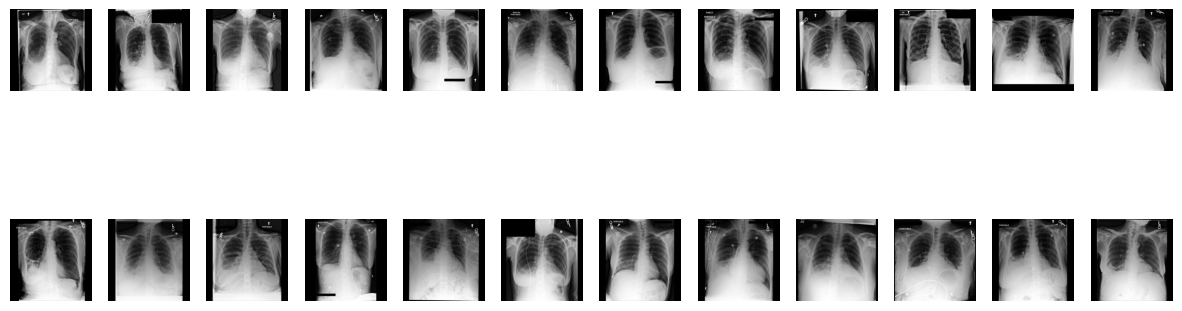

In [46]:
search.image_search('pulmonary edema')

In [48]:
Demo_image_dataset['caption'][0]

NameError: name 'Demo_image_dataset' is not defined

In [243]:
substring = 'pacemaker'
substr = Demo_image_dataset[Demo_image_dataset.apply(lambda row: row.astype(str).str.contains(substring, case=False).any(), axis=1)]
substr

,caption,image
32,"moderate cardiomegaly is increased since , per...",/media/andrew/HD-GDU3/498/complete_imageset/19...
33,comparison is made to previous radiographs fro...,/media/andrew/HD-GDU3/498/complete_imageset/19...
39,there is no evidence of pneumothorax. the left...,/media/andrew/HD-GDU3/498/complete_imageset/19...
51,"comparison with the study dated at p.m., there...",/media/andrew/HD-GDU3/498/complete_imageset/19...
61,again seen is a left apical pneumothorax that ...,/media/andrew/HD-GDU3/498/complete_imageset/19...
...,...,...
75523,the tip of the endotracheal tube projects cm a...,/media/andrew/HD-GDU3/498/complete_imageset/10...
75524,"as compared to previous radiograph, the right ...",/media/andrew/HD-GDU3/498/complete_imageset/10...
75525,enlarging right pleural effusion without pulmo...,/media/andrew/HD-GDU3/498/complete_imageset/10...
75529,a left-sided pacemaker remains in place. a rig...,/media/andrew/HD-GDU3/498/complete_imageset/10...


In [244]:
for row in substr.head().index:
    print (f'{row}: {substr.caption[row]}')
    print ('')

    #print (df.head()['caption'])

32: moderate cardiomegaly is increased since , perhaps a function of lower lung volumes. mild to moderate pulmonary edema and small bilateral pleural effusions are stable. no pneumothorax. infusion port catheter ends in the right atrium and atrioventricular pacer leads continuous from the left pectoral pacemaker are all unchanged. 

33: comparison is made to previous radiographs from . there are two pigtail catheters within the right chest. there is again seen a small right-sided pleural effusion with some loculation along the right lateral chest wall. this appears unchanged. there are no pneumothoraces. there is a left-sided pacemaker. slight blunting of the left cp angle is again seen and unchanged. there are no signs for overt pulmonary edema or focal consolidation. 

39: there is no evidence of pneumothorax. the left pectoral pacemaker and right port-a-cath are in unchanged position. no pleural effusions. slightly lower lung volumes than on location of the previous radiograph. mini

In [245]:
def image_text_comp(id):
    search.zero_shot(f'{Demo_image_dataset["image"][id]}')
    print ("")
    print (Demo_image_dataset['caption'][id])

label: heart size enlarged | 0.148
label: pulmonary edema | 0.147
label: device | 0.146
label: lungs fully expanded | 0.145
label: mild pulmonary edema | 0.141
label: collapsed | 0.138
label: pacemaker | 0.135

again seen is a left apical pneumothorax that has not significantly changed in size. there is opacity in the right lower lobe that could be due to volume loss or infiltrate. no right pneumothorax is seen. the et tube, swan-ganz catheter, pacemaker, and right subclavian line, and ng tube are unchanged. 


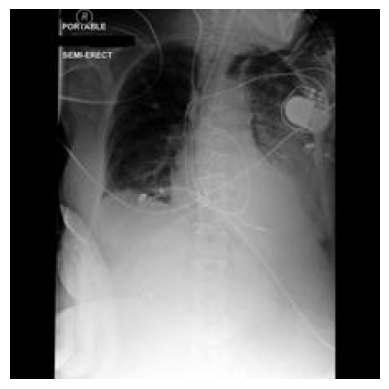

In [248]:
image_text_comp(61)

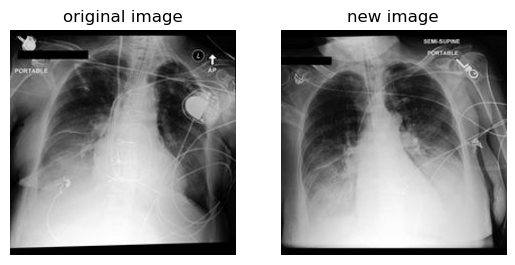

In [253]:
search.analogy(f'{Demo_image_dataset["image"][35]}')